<a href="https://colab.research.google.com/github/suann124/AIinTeaching/blob/main/lectures/L4_Firstorder_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First-Order Systems

## What are first-order systems?

Scalar first-order linear systems are the simplest type of dynamical systems that can be described by a first-order ordinary differential equation

$$
\frac{dx(t)}{dt} = A x(t) + B u(t)
$$

where $A \in \mathbb{R}$ and $B \in \mathbb{R}$. Here, $x(t)$ is the state of the system at time $t$ and $u(t)$ is the input to the system at time $t$.
Let's consider that the system is initialized at the initial condition $x_{0} \in \mathbb{R}$.


> Wonder why: What makes a differential equation an __ordinary__ differential equation?

##Example: Adaptive Cruise Control

In adaptive cruise control, we want to regulate the vehicle speed by applying engine torque. To keep things simple, we will ignore road slope and other disturbances for now, and focus only on how torque changes the speed.

This gives us a very clean first-order system: the car speeds up when torque is applied, and it naturally slows down due to drag when no torque is applied.


From Newton's law, the vehicle dynamics can be written as

$$
m \dot v(t) = k_u u(t) - b v(t),
$$

where
* $v(t)$ is the vehicle speed,
* $u(t)$ is the engine torque input,
* $m$ is the vehicle mass,
* $k_u$ converts torque to driving force,
* $b$ is the drag coefficient.

Dividing through by $m$ gives

$$
\dot v(t) = -\frac{b}{m} v(t) + \frac{k_u}{m} u(t).
$$

By defining the state as $x(t) = v(t)$, the dynamics can be written in state-space form as

$$
\dot x(t) = A x(t) + B u(t)
$$

with parameters

$$
A = -\frac{b}{m} \text{ and } B = \frac{k_u}{m}.
$$

ADD SIMULATIONS
SHOW MULTIPLE INITIAL CONDITIONS

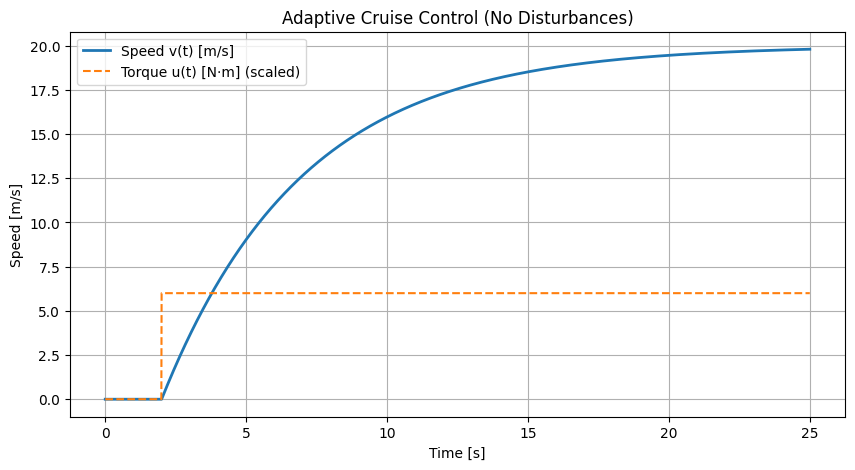

In [ ]:
# @title Adaptive Cruise Control: Simple First-Order Model (No Disturbances)

import numpy as np
import matplotlib.pyplot as plt

# Parameters
m = 1500.0    # mass [kg]
b = 300.0     # drag coefficient [N*s/m]
k_u = 50.0    # torque-to-force gain [N per N·m]

# Simulation time
t_final = 25.0
dt = 0.01
t = np.arange(0.0, t_final + dt, dt)

# Input: engine torque profile
def torque_input(t):
    # Step in torque at t = 2 s
    return 120.0 * (t >= 2.0)

# Dynamics: m dv/dt = k_u u - b v
def simulate(t, v0=0.0):
    u = torque_input(t)
    v = np.zeros_like(t)
    v[0] = v0
    a = -b/m
    bu = k_u/m
    for k in range(len(t)-1):
        dv = a*v[k] + bu*u[k]
        v[k+1] = v[k] + dt*dv
    return v, u

# Run simulation
v, u = simulate(t)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(t, v, label="Speed v(t) [m/s]", linewidth=2)
plt.plot(t, u/20.0, "--", label="Torque u(t) [N·m] (scaled)")  # scaled for visibility
plt.title("Adaptive Cruise Control (No Disturbances)")
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.legend()
plt.grid(True)
plt.show()

In reality, a car doesn't just respond to torque. Road slope and other forces (like wind drag or rolling resistance) act as disturbances. These affect the speed even if the driver (or controller) applies the same torque.

To capture this, we add two disturbance terms:
* Road inclination $\theta(t)$, which creates an uphill or downhill force,
* External disturbance $w(t)$, which represents extra forces such as wind gusts.

### Vehicle Dynamics

The full longitudinal dynamics are

$$
m \dot v(t) = k_u u(t) - b v(t) - m g \theta(t) + w(t),
$$

where
* $- m g \theta(t)$ models the component of gravity on a slope (using $\sin \theta \approx \theta$ for small angles), and
* $w(t)$ is a lumped disturbance force.

Dividing through by $m$ gives

$$
\dot v(t) = -\frac{b}{m} v(t) + \frac{k_u}{m} u(t) - g \theta(t) + \frac{1}{m} w(t).
$$

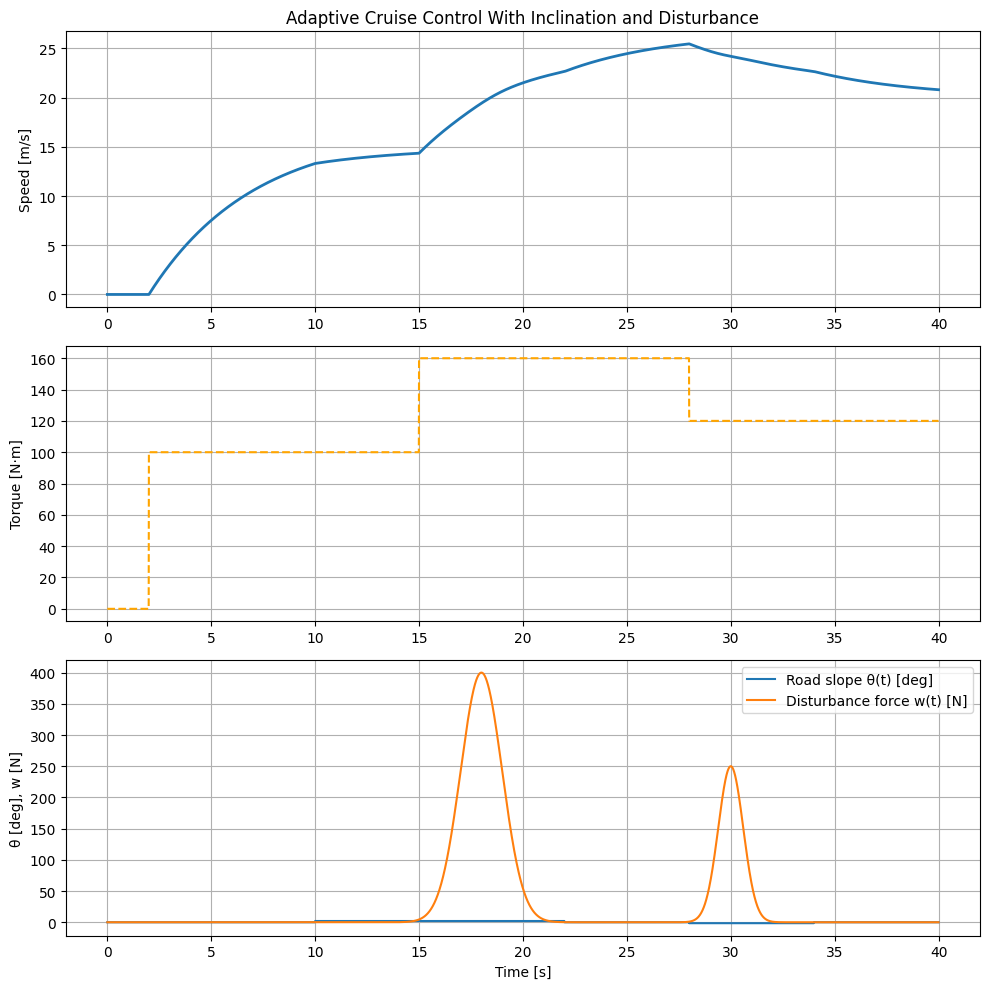

In [ ]:
# @title Adaptive Cruise Control: First-Order Model With Disturbances

import numpy as np
import matplotlib.pyplot as plt

# Parameters
m = 1500.0
b = 300.0
k_u = 50.0
g = 9.81

# Simulation time
t_final = 40.0
dt = 0.01
t = np.arange(0.0, t_final + dt, dt)

# Inputs
def torque_input(t):
    u = np.zeros_like(t)
    u += 100.0 * (t >= 2.0)
    u += 60.0  * (t >= 15.0)
    u -= 40.0  * (t >= 28.0)
    return u

def road_inclination(t):
    theta = np.zeros_like(t)
    theta += (2*np.pi/180.0) * ((t >= 10) & (t < 22))   # +2 deg uphill
    theta += (-1.5*np.pi/180.0) * ((t >= 28) & (t < 34)) # -1.5 deg downhill
    return theta

def disturbance_force(t):
    w = np.zeros_like(t)
    w += 400.0 * np.exp(-0.5*((t-18.0)/1.0)**2)  # gust at 18s
    w += 250.0 * np.exp(-0.5*((t-30.0)/0.6)**2)  # gust at 30s
    return w

# Dynamics: m dv/dt = k_u u - b v - m g theta + w
def simulate(t, v0=0.0):
    u = torque_input(t)
    theta = road_inclination(t)
    w = disturbance_force(t)
    v = np.zeros_like(t)
    v[0] = v0
    for k in range(len(t)-1):
        dv = (-b/m)*v[k] + (k_u/m)*u[k] - g*theta[k] + (1/m)*w[k]
        v[k+1] = v[k] + dt*dv
    return v, u, theta, w

# Run simulation
v, u, theta, w = simulate(t)

# Plot results
plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plt.plot(t, v, label="Speed v(t) [m/s]", linewidth=2)
plt.title("Adaptive Cruise Control With Inclination and Disturbance")
plt.ylabel("Speed [m/s]")
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(t, u, "--", label="Torque u(t) [N·m]", color="orange")
plt.ylabel("Torque [N·m]")
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(t, theta*180/np.pi, label="Road slope θ(t) [deg]")
plt.plot(t, w, label="Disturbance force w(t) [N]")
plt.xlabel("Time [s]")
plt.ylabel("θ [deg], w [N]")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Solving the First-Order System
The solution to the first-order linear ODE
$$
\boxed{
\dot{x}(t) = a x(t) + b u(t), \quad x(0) = x_0
}
$$
is
$$
x(t) = e^{at} x_0 + \int_0^t e^{a(t-\tau)} b u(\tau)\, d\tau
\tag{*}
$$

### Verifying the Solution

**Initial condition:**
$$
x(0) = e^{a\cdot0} x_0 + 0 = x_0 \quad \tag{✔ satisfied}
$$

**Differential equation:**
$$
\begin{align*}
\frac{d}{dt}x(t)
&= a e^{at}x_0
  + a \int_0^t e^{a(t-\tau)} b u(\tau)\, d\tau
  + e^{a(t-t)} b u(t) \\[4pt]
&= a\!\left[e^{at}x_0 + \int_0^t e^{a(t-\tau)} b u(\tau)\, d\tau\right] + b u(t) \\[4pt]
&= a x(t) + b u(t) \quad \tag{✔ satisfied}
\end{align*}
$$



### Decomposition of the Solution

We can separate the total response into two parts:

<!-- <div style="border:2px solid #f39c12; background-color:#fff3cd; padding:8px 12px; border-radius:6px; font-weight:bold; text-align:center;">
Complete Solution = Free Response + Forced Response
</div> -->

$$
\begin{align*}
x(t) &= x_{\text{free}}(t) + x_{\text{forced}}(t) \\[4pt]
&=
\underbrace{e^{at} x_0}_{\text{Free response: } u \equiv 0}
+
\underbrace{\int_0^t e^{a(t-\tau)} b u(\tau)\, d\tau}_{\text{Forced response: } x_0 = 0}
\end{align*}
$$


> 👉 Try reasoning the **free response** and the **forced response** separately to reason about the complete solution!
>
> **Prompt an LLM:**
> ```text
> Explain the difference between the **free response** and the **forced response** in  
> x(t) = e^{at}x₀ + ∫₀ᵗ e^{a(t−τ)}b u(τ) dτ  
> - Describe what happens when u(t)=0 or x₀=0  
> - How does the parameter a affect the long-term behavior?
> ```

<details>
<summary><strong>💡 Solution (click to expand)</strong></summary>

- **Free Response**  
  The natural motion of the system when no input is applied:  
  $$
  x_{\text{free}}(t) = e^{at} x_0
  $$
  It depends only on the **initial condition** and the system parameter **a**.

- **Forced Response**  
  The part of the response driven by the **input** \(u(t)\):  
  $$
  x_{\text{forced}}(t) = \int_0^t e^{a(t-\tau)} b u(\tau)\, d\tau
  $$
  It shows how the input influences the state through the system dynamics.

</details>

## Free Response and Stability

Consider the system  
$$
\dot{x} = a x + b u, \quad x(0) = x_0, \quad u \equiv 0
$$

Then the free response is given by  
$$
x(t) = e^{a t} x_0
$$

We analyze stability under three cases for $a$:

---

#### 1. $a < 0$, **Asymptotically stable**:  
$$
e^{a t} x_0 \to 0 \quad \text{as } t \to \infty
$$  

$x(t)$ approaches to the stable point $0$ for all $x_0$.

---

#### 2. $a > 0$, **Unstable**:  
$$
|e^{a t} x_0| \text{ grows as } t \text{ increases} \text{ (assuming $x_0 \neq 0$)}
$$  

For $x_0 \neq 0$, $x(t)$ diverges to $-∞$ or $+∞$ depending on the sign of $x_{0}$.

For $x_0 = 0$, $x(t)$ remains at $0$.

---

#### 3. $a = 0$, **Marginally stable (or limitedly stable)**:  
$$
x(t) = x_0 \text{ (constant over time)}
$$  

$x(t)$ remains at $x_0$ for all initial conditions $x_0$.


**Question:** Does stability depend on the initial condition or is the property of the system?

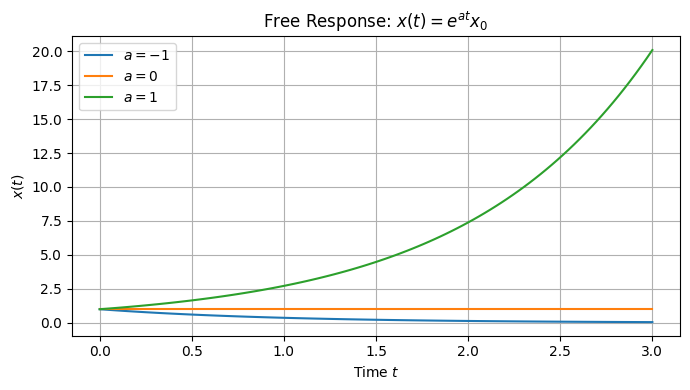

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
x0 = 1.0               # initial condition
t = np.linspace(0, 10, 100)  # time vector
a_values = [-1, 0, 1]       # test three cases

# Plot
plt.figure(figsize=(7, 4))
for a in a_values:
    x = np.exp(a * t) * x0
    plt.plot(t, x, label=f"$a = {a}$")

# Labels and legend
plt.title(r"Free Response: $x(t) = e^{a t} x_0$")
plt.xlabel("Time $t$")
plt.ylabel("$x(t)$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Free Response and Time Constant

The solution of the system  
$$
x(t) = e^{a t} x_0
$$

Consider the case $a < 0$ (i.e., asymptotically stable).

At $t = 0$, the slope is  
$$
\dot{x}(0) = a x_0
$$

The **time constant** $T$ is defined as  
$$
T = \frac{1}{|a|} = -\frac{1}{a}, \quad \text{for } a < 0
$$

Hence,  
$$
x(t) = e^{a t} x_0 = e^{-t/T} x_0
$$

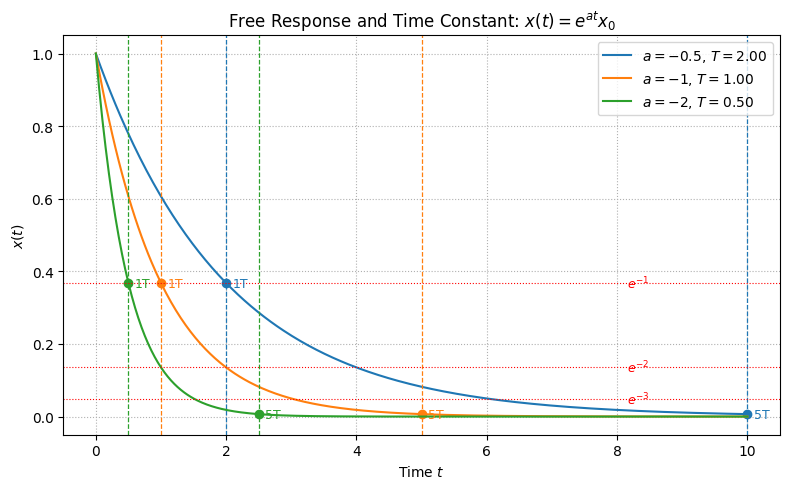

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
x0 = 1.0
t = np.linspace(0, 10, 400)
a_values = [-0.5, -1, -2]  # asymptotically stable cases (a < 0)
colors = ['tab:blue', 'tab:orange', 'tab:green']  # consistent colors

plt.figure(figsize=(8, 5))

for a, color in zip(a_values, colors):
    T = -1 / a
    x = np.exp(a * t) * x0
    plt.plot(t, x, color=color, label=f"$a = {a}$, $T = {T:.2f}$")

    # Plot vertical dashed lines at 1T and 5T in same color
    for k, label_text in zip([1, 5], ['1T', '5T']):
        tT = k * T
        plt.axvline(tT, color=color, linestyle='--', linewidth=0.9)
        plt.plot(tT, np.exp(a * tT) * x0, 'o', color=color)
        plt.text(tT + 0.1, np.exp(a * tT) * x0, f"{label_text}",
                 color=color, va='center', fontsize=9)

# Add horizontal e^{-k} reference lines
for k in range(1, 4):
    plt.axhline(np.exp(-k), color='r', linestyle=':', linewidth=0.8)
    plt.text(8.15, np.exp(-k), f"$e^{{-{k}}}$", color='r', va='center', fontsize=9)

# Labels and formatting
plt.title(r"Free Response and Time Constant: $x(t) = e^{a t} x_0$")
plt.xlabel("Time $t$")
plt.ylabel("$x(t)$")
plt.grid(True, which='both', linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()


## Practical Uses of the Time Constant

The **time constant** $ T = \frac{1}{|a|} $ is a key concept in system dynamics, control, and signal processing. It describes how fast a system responds to changes or disturbances.

---

### ⚙️ 1. Understanding System Speed / Response Rate
- The time constant determines **how fast** a system responds to changes.  
- For a first-order system $ x(t) = e^{-t/T}x_0 $:
  - After $ 1T $: about 37% of the initial value remains  
  - After $ 3T $: about 5% remains  
  - After $ 5T $: about 1% remains  
- Therefore, the system is considered **settled** after roughly **five time constants**.

---

### 🔧 2. Mechanical and Aerospace Systems
- For a **mass-damper system**,  
  $$
  m \ddot{x} + b \dot{x} = 0
  $$
  the velocity response follows  
  $$
  \dot{x}(t) = \dot{x}_0 e^{-t/T}
  $$
  where  
  $$
  T = \frac{m}{b}.
  $$
- **Interpretation:**  
  The larger the mass (inertia), the slower the system responds. The greater the damping coefficient $b$, the faster the system settles.  
- **Example – Aerospace Application:**  
  Consider a small unmanned aerial vehicle (UAV) performing altitude control.  
  - The **mass** represents the vehicle’s inertia resisting acceleration.  
  - The **damping** (from drag or control feedback) dissipates energy and smooths motion.  
  - The time constant $ T = \frac{m}{b} $ tells how quickly altitude or pitch rate stabilizes after a thrust or control input.  
  In practice, flight control systems use the time constant to ensure that roll, pitch, and yaw responses settle within acceptable time limits for maneuverability and comfort.

---

### ⚡ 3. Electrical Circuits
- **Resistor-Capacitor Circuit:** $ T = RC $
  - Describes how quickly a capacitor charges or discharges.  
  - After $ 5RC $, the capacitor is ~99% charged or discharged.
- **Resistor-Inductor Circuit:** $ T = \frac{L}{R} $
  - Determines how fast current builds up through an inductor.
- In circuit design, engineers use the time constant to shape **filter bandwidths**, **delay responses**, and **switching speeds**.

---

### 🎛️ 4. Control Systems
- The time constant defines **transient response** characteristics.
- Systems with several time constants can often be approximated by their **dominant** one.
- Used for controller design and performance metrics such as rise time and settling time:
  $$
  t_{\text{settling}} \approx 5T
  $$
  (We will learn about these concepts in later lectures.)
- In aerospace control (e.g., autopilots), desired time constants are often specified for roll or pitch dynamics to ensure responsive but stable flight.

---

### 📡 5. Signal Processing and Filters
- For a first-order **low-pass filter**, $ T = \frac{1}{2\pi f_c} $, where $ f_c $ is the cutoff frequency.
- Determines how quickly high-frequency components are attenuated:
  - Small $T$ → fast response, wide bandwidth.  
  - Large $T$ → slow response, smoother output.
- Used in avionics sensors to remove noise from accelerometers or gyroscopes while maintaining fast reaction times.

---

### 🧠 6. Biological and Economic Models
- **Neurons:** Membrane time constant $ T_m = R_m C_m $ defines how fast voltage changes.  
- **Economics:** Time constants describe adaptation rates or adjustment speeds in dynamic models.

---

In summary, the **time constant** provides a universal measure of how quickly a system reacts and settles — whether it’s a **mechanical aircraft response**, an **electrical circuit**, or a **thermal or biological system**.  
In aerospace, engineers often design controllers to achieve **desired time constants** that balance **stability**, **responsiveness**, and **passenger comfort**.


## Forced Response

### 🌱 What is the forced response?

For a **linear time-invariant (LTI)** system:
$$
\frac{dx(t)}{dt} = a\,x(t) + b\,u(t)
$$

the total response can be split into two components:
$$
x(t) = x_{\text{natural}}(t) + x_{\text{forced}}(t)
$$

| Part | Caused by | Exists if input = 0? | Depends on IC? | Behavior (for stable systems) |
|------|------------|----------------------|----------------|-------------------------------|
| **Natural response** | The system’s own dynamics | ✅ Yes | ✅ Yes | Decays over time (transient) |
| **Forced response** | The external input | ❌ No | ❌ No | Persists as long as input acts |

* The **natural response** represents how the system’s stored energy (initial state) decays.  
* The **forced response** represents how the system reacts to external forcing (input).

Example intuition:  
If you push a mass-spring-damper system, its oscillation after you stop pushing is the *natural response*,  
while its steady deformation under a constant force is the *forced response*.


### We now consider the *forced response* of a first-order system subjected to a **step input**.

Consider the system
$$
\frac{dx(t)}{dt} = a\,x(t) + b\,u(t), \qquad x(0)=x_0
$$

and the **step input**

$$
u(t) =
\begin{cases}
0, & t<0,\\[3pt]
u_m, & t\ge 0.
\end{cases}
$$

This is known as a **step input** of magnitude $u_m$.


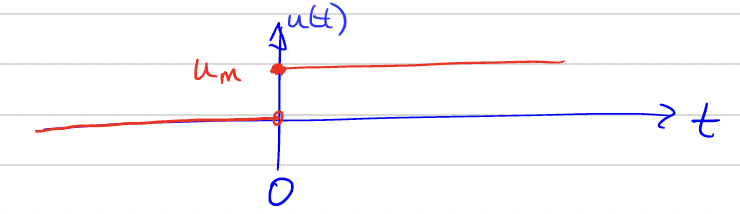

The total solution is obtained from the variation-of-constants formula:
$$
x(t) = e^{a t}x_0 + \int_{0}^{t} e^{a(t-\tau)} b\,u(\tau)\, d\tau .
$$

For a step input ($u(\tau)=u_m$ for $\tau\ge0$):
$$
\begin{aligned}
x(t)
&= e^{a t}x_0 + b\,u_m\, e^{a t} \int_{0}^{t} e^{-a\tau}\, d\tau \\
&= e^{a t}x_0 + b\,u_m\, e^{a t}\,\frac{1 - e^{-a t}}{a} \\[2mm]
&= e^{a t}x_0 + \frac{b\,u_m}{a}\,(e^{a t} - 1)
\end{aligned}
$$

For a **zero initial condition** ($x_0 = 0$), the first term vanishes, leaving only the **forced response**:
$$
x(t) = -\frac{b}{a}u_m\,(1 - e^{a t})
$$

---

#### 📈 Interpretation

* For $a < 0$, the exponential term $e^{a t}$ decays to zero → the system is **stable**.  
* The steady-state value (as $t \to \infty$) is:
  $$
  x_{ss} = -\frac{b}{a}\,u_m
  $$
* The **DC gain** is the ratio of steady-state output to steady-state input:
  $$
  \frac{x_{ss}}{u_m} = -\frac{b}{a}.
  $$

The response approaches its steady-state exponentially:
$$
x(t) = x_{ss}\,\big(1 - e^{a t}\big)
$$
Define the **time constant**
$$
\tau = \frac{1}{|a|}.
$$

At $t = \tau$, the output reaches about **63.2%** of its final value:
$$
x(\tau) = x_{ss}\,(1 - e^{-1}) \approx 0.632\,x_{ss}.
$$

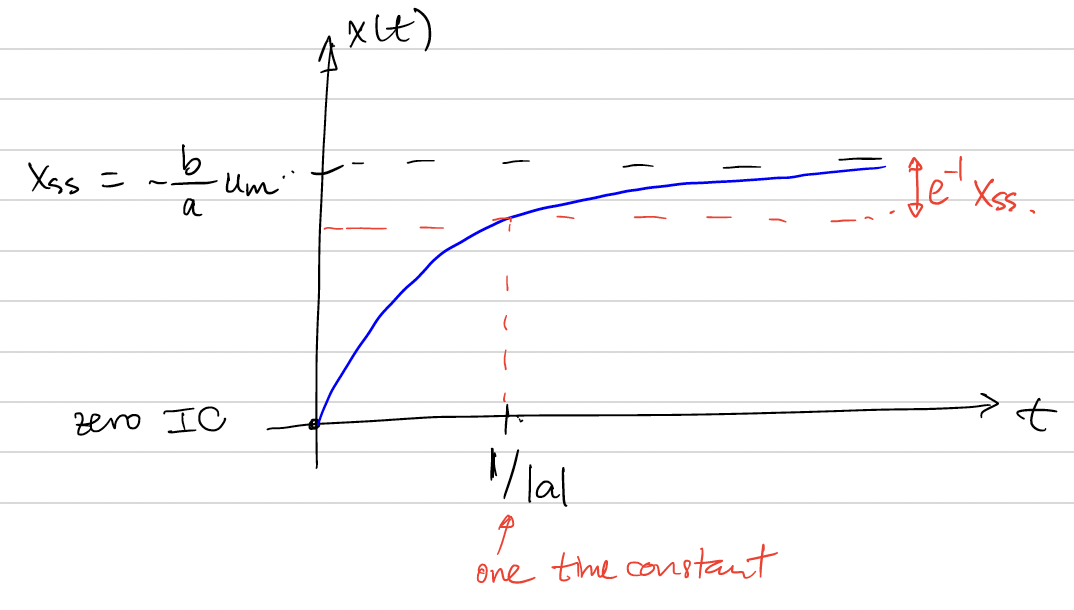

## Forced Response Simulation for Different Initial Conditions

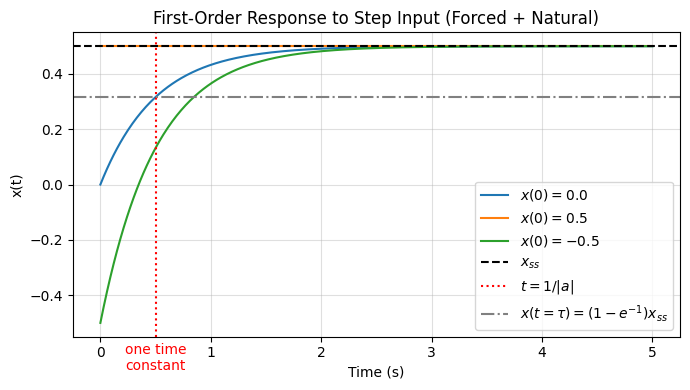

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# --- System Parameters ---
a = -2.0      # system coefficient (a < 0 for stability)
b = 1.0       # input coefficient
um = 1.0      # step magnitude
t = np.linspace(0, 5, 500)

# --- Response function ---
def response(a, b, um, x0, t):
    """Total response = natural + forced."""
    x_forced = -b/a * um * (1 - np.exp(a*t))
    x_natural = x0 * np.exp(a*t)
    return x_forced + x_natural

# --- Simulate for several initial conditions ---
x0_values = [0.0, 0.5, -0.5]
plt.figure(figsize=(7, 4))
for x0 in x0_values:
    plt.plot(t, response(a, b, um, x0, t), label=f"$x(0)={x0}$")

# --- Compute key quantities ---
xss = -b/a * um                # steady-state value
tau = 1/abs(a)                 # time constant
x_tau = (1 - np.exp(-1)) * xss # value at one time constant (e^-1 * xss above zero IC)

# --- Plot steady-state and time-constant markers ---
plt.axhline(xss, color='k', linestyle='--', label=r"$x_{ss}$")
plt.axvline(tau, color='r', linestyle=':', label=r"$t = 1/|a|$")
plt.axhline(x_tau, color='gray', linestyle='-.', label=r"$x(t=\tau) = (1-e^{-1})x_{ss}$")

# --- Label "one time constant" on x-axis ---
plt.text(tau, plt.ylim()[0] + -0.12*(plt.ylim()[1]-plt.ylim()[0]),
         "one time\nconstant", color='r', ha='center', va='bottom', rotation=0)

# --- Formatting ---
plt.xlabel("Time (s)")
plt.ylabel("x(t)")
plt.title("First-Order Response to Step Input (Forced + Natural)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()